# Setup

In [1]:
import os
import time

import numpy as np
import scipy.io as sio
import spectral
from sklearn import cluster
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score
from tensorflow import keras

def applyPCA(X, numComponents=75):
    xshape = X.shape
    pca = PCA(n_components=numComponents, whiten=True)
    PCs = pca.fit_transform(X.reshape(-1, xshape[2])).reshape(xshape[0], xshape[1], numComponents)
    return PCs

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    zeroPaddedX[margin:X.shape[0] + margin, margin:X.shape[1] + margin, :] = X
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patchesData[patchIndex, :, :, :] = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0] - 1
    return patchesData, patchesLabels

def count_FLOPs(model):
    FLOPs = 0
    for i in range(len(model.layers)):
        layer = model.layers[i]
        if layer.__class__.__name__ == 'Conv3D':
            FLOPs += 2*np.prod(layer.kernel_size[:3])*np.prod(layer.output_shape[1:5])
        if layer.__class__.__name__ == 'Conv2D':
            FLOPs += 2*np.prod(layer.kernel_size[:2])*layer.input_shape[3]*np.prod(layer.output_shape[1:4])
        if layer.__class__.__name__ in ('MaxPooling3D', 'AveragePooling3D'):
            FLOPs += np.prod(layer.pool_size[:3])*np.prod(layer.output_shape[1:5])
        if layer.__class__.__name__ in ('MaxPooling2D', 'AveragePooling2D'):
            FLOPs += np.prod(layer.pool_size[:2])*np.prod(layer.output_shape[1:4])
        if layer.__class__.__name__ == 'GlobalAveragePooling3D':
            FLOPs += np.prod(layer.input_shape[1:5])
        if layer.__class__.__name__ == 'GlobalAveragePooling2D':
            FLOPs += np.prod(layer.input_shape[1:4])             
        if layer.__class__.__name__ in ('Activation', 'Add', 'Multiply'):
            FLOPs += np.prod(layer.output_shape[1:])            
        if layer.__class__.__name__ == 'Dense':
            FLOPs += 2*layer.input_shape[1]*layer.output_shape[1]
        #if layer.__class__.__name__ == 'BatchNormalization':               
    return FLOPs

HSI = sio.loadmat(os.path.join(os.getcwd(),'data/Indian_pines_corrected.mat'))['indian_pines_corrected']
GT = sio.loadmat(os.path.join(os.getcwd(),'data/Indian_pines_gt.mat'))['indian_pines_gt']
test_ratio = 0.9

# Visualization

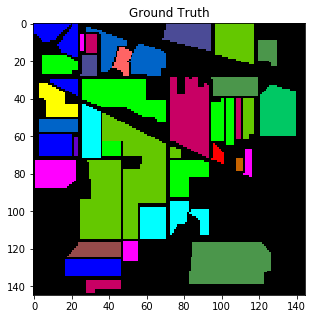

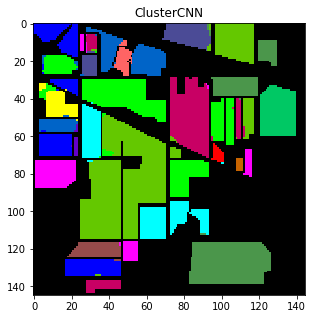

In [20]:
# original images
#view=spectral.imshow(HSI, (26, 14, 8), figsize=(5, 5), classes=GT, title='Pavia University')

# lulc maps
predictions = np.argmax(model.predict(X), axis=1)+1
outputs = np.zeros(GT.shape)
k = 0
for i in range(GT.shape[0]):
    for j in range(GT.shape[1]):
        if int(GT[i,j]) == 0 :
            continue
        else:
            outputs[i, j] = predictions[k]
            k += 1
            
ground_truth = spectral.imshow(classes = GT,figsize =(5,5), title='Ground Truth')
#spectral.save_rgb(str(dataset)+"_ground_truth.jpg", GT, colors=spectral.spy_colors)
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5), title='ClusterCNN')
#spectral.save_rgb(str(dataset)+"_ClusterCNN_"+expnum+".jpg", outputs.astype(int), colors=spectral.spy_colors)

# DCCNN
https://github.com/stop68/Remote-Sensing-Image-Classification/blob/master/demo_keras.py

In [2]:
from Utils import networks as nw

patch = 5  # if patch==5, WCRN DCCNN. if patch==7, BDMA.
im = applyPCA(HSI,numComponents=15)
im1x,im1y,im1z = im.shape
cls1 = np.max(GT)

X, y = createImageCubes(im, GT, windowSize=patch)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345, stratify=y)
# x_train,y_train = rscls.make_sample(x_train,y_train)  # augmentation
y_train = keras.utils.to_categorical(np.asarray(y_train))

model = nw.DCCNN(im1z, patch, cls1) 
adadelta1 = keras.optimizers.Adadelta(lr=1.0)
adadelta2 = keras.optimizers.Adadelta(lr=0.2)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=2)

model.summary()
print('PatchSize:', patch, 'FLOPs:', format(count_FLOPs(model), ','))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 5, 15)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 5, 128)    2048        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 128)    17408       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 1, 1, 128)    0           conv2d[0][0]                     
______________________________________________________________________________________________

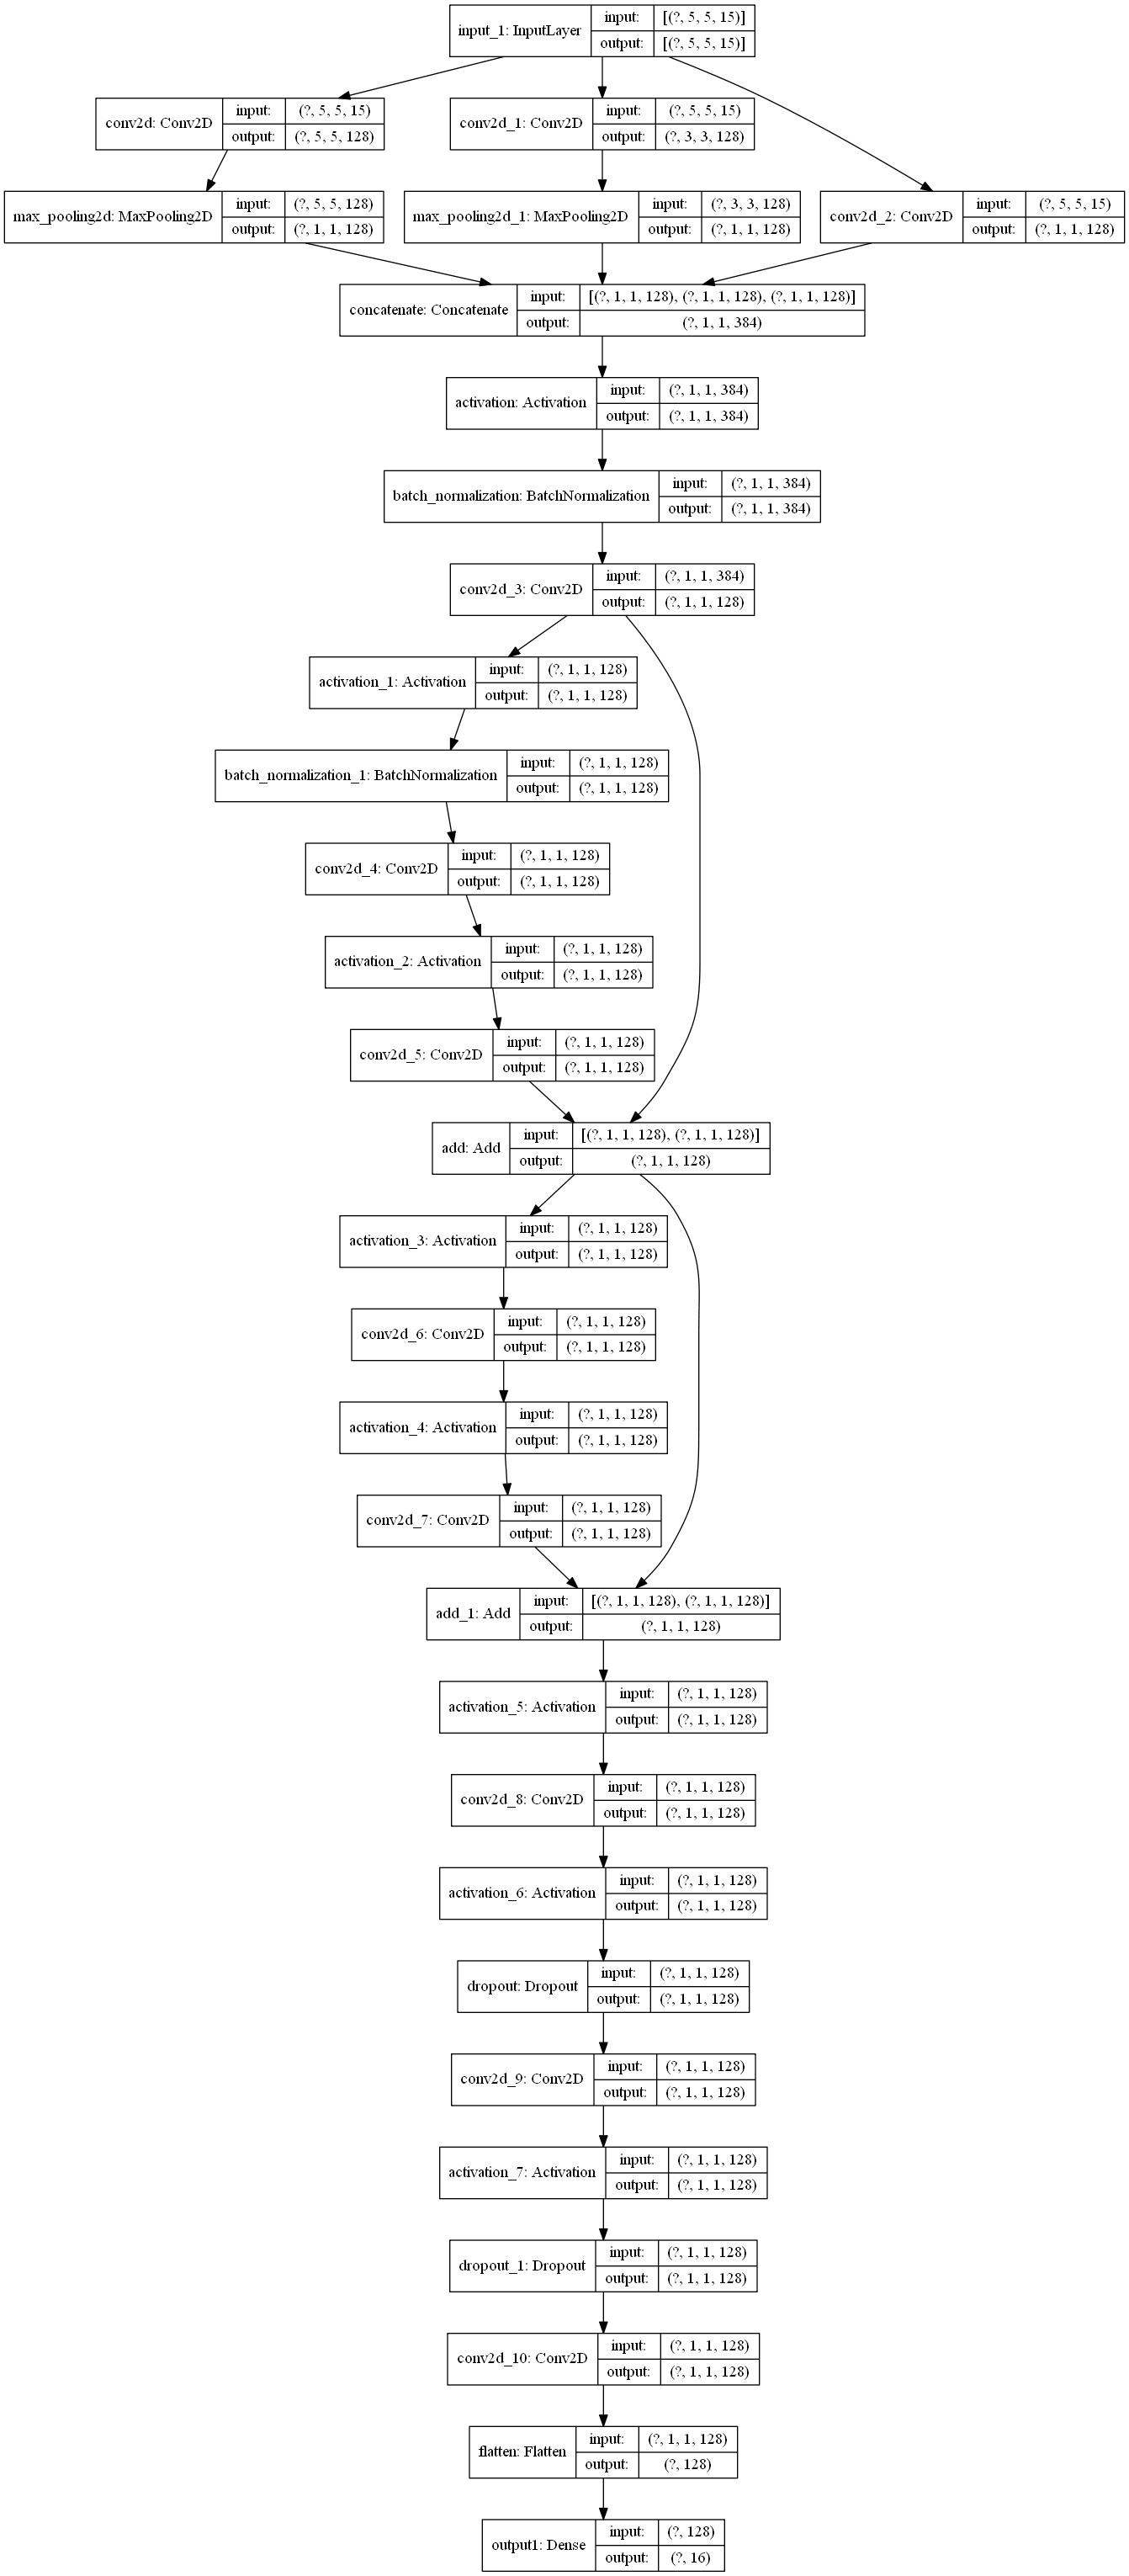

In [3]:
keras.utils.plot_model(model, 'model_dccnn.png', show_shapes=True)

In [4]:
time1 = int(time.time())
# first train the model with lr=1.0    
model.compile(loss='categorical_crossentropy',optimizer=adadelta1,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=20,epochs=80,verbose=0,shuffle=True)

# then train the model with lr=0.1; if loss not decrease for 5 epoches, stop training
model.compile(loss='categorical_crossentropy',optimizer=adadelta2,metrics=['accuracy'])   
model.fit(x_train,y_train,batch_size=20,epochs=20,verbose=0,shuffle=0,callbacks=[early_stopping])
time2 = int(time.time())

# predict
y_pred = np.argmax(model.predict(x_test), axis=1)
oa = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print('DBMA:', oa, kappa, ' Time Comsumption:', time2-time1)

DBMA: 0.8553929539295393 0.8354154223391939  Time Comsumption: 178


# DBMA
https://github.com/stop68/Remote-Sensing-Image-Classification/blob/master/demo_keras.py

In [6]:
from Utils import networks as nw

patch = 7  # if patch==5, WCRN DCCNN. if patch==7, BDMA. if patch==9, ResNet-avg.
im = applyPCA(HSI,numComponents=15)
im1x,im1y,im1z = im.shape
cls1 = np.max(GT)

X, y = createImageCubes(im, GT, windowSize=patch)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3], -1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345, stratify=y)
# x_train,y_train = rscls.make_sample(x_train,y_train)  # augmentation
y_train = keras.utils.to_categorical(np.asarray(y_train))
#x_train = x_train.reshape(x_train.shape[0],patch,patch,im1z,-1) # 3D CNN, samples are 5-dimensional
#x_test = x_test.reshape(x_test.shape[0],patch,patch,im1z,-1)    # 3D CNN, samples are 5-dimensional

model = nw.DBMA(im1z, patch, cls1)  # 3D CNN, samples are 5-dimensional
adadelta1 = keras.optimizers.Adadelta(lr=1.0)
adadelta2 = keras.optimizers.Adadelta(lr=0.2)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=2)

model.summary()
print('PatchSize:', patch, 'FLOPs:', format(count_FLOPs(model), ','))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 7, 7, 15, 1) 0                                            
__________________________________________________________________________________________________
conv3d_11 (Conv3D)              (None, 7, 7, 5, 24)  192         input_3[0][0]                    
__________________________________________________________________________________________________
conv3d_16 (Conv3D)              (None, 7, 7, 1, 24)  384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 7, 7, 5, 24)  96          conv3d_11[0][0]                  
____________________________________________________________________________________________

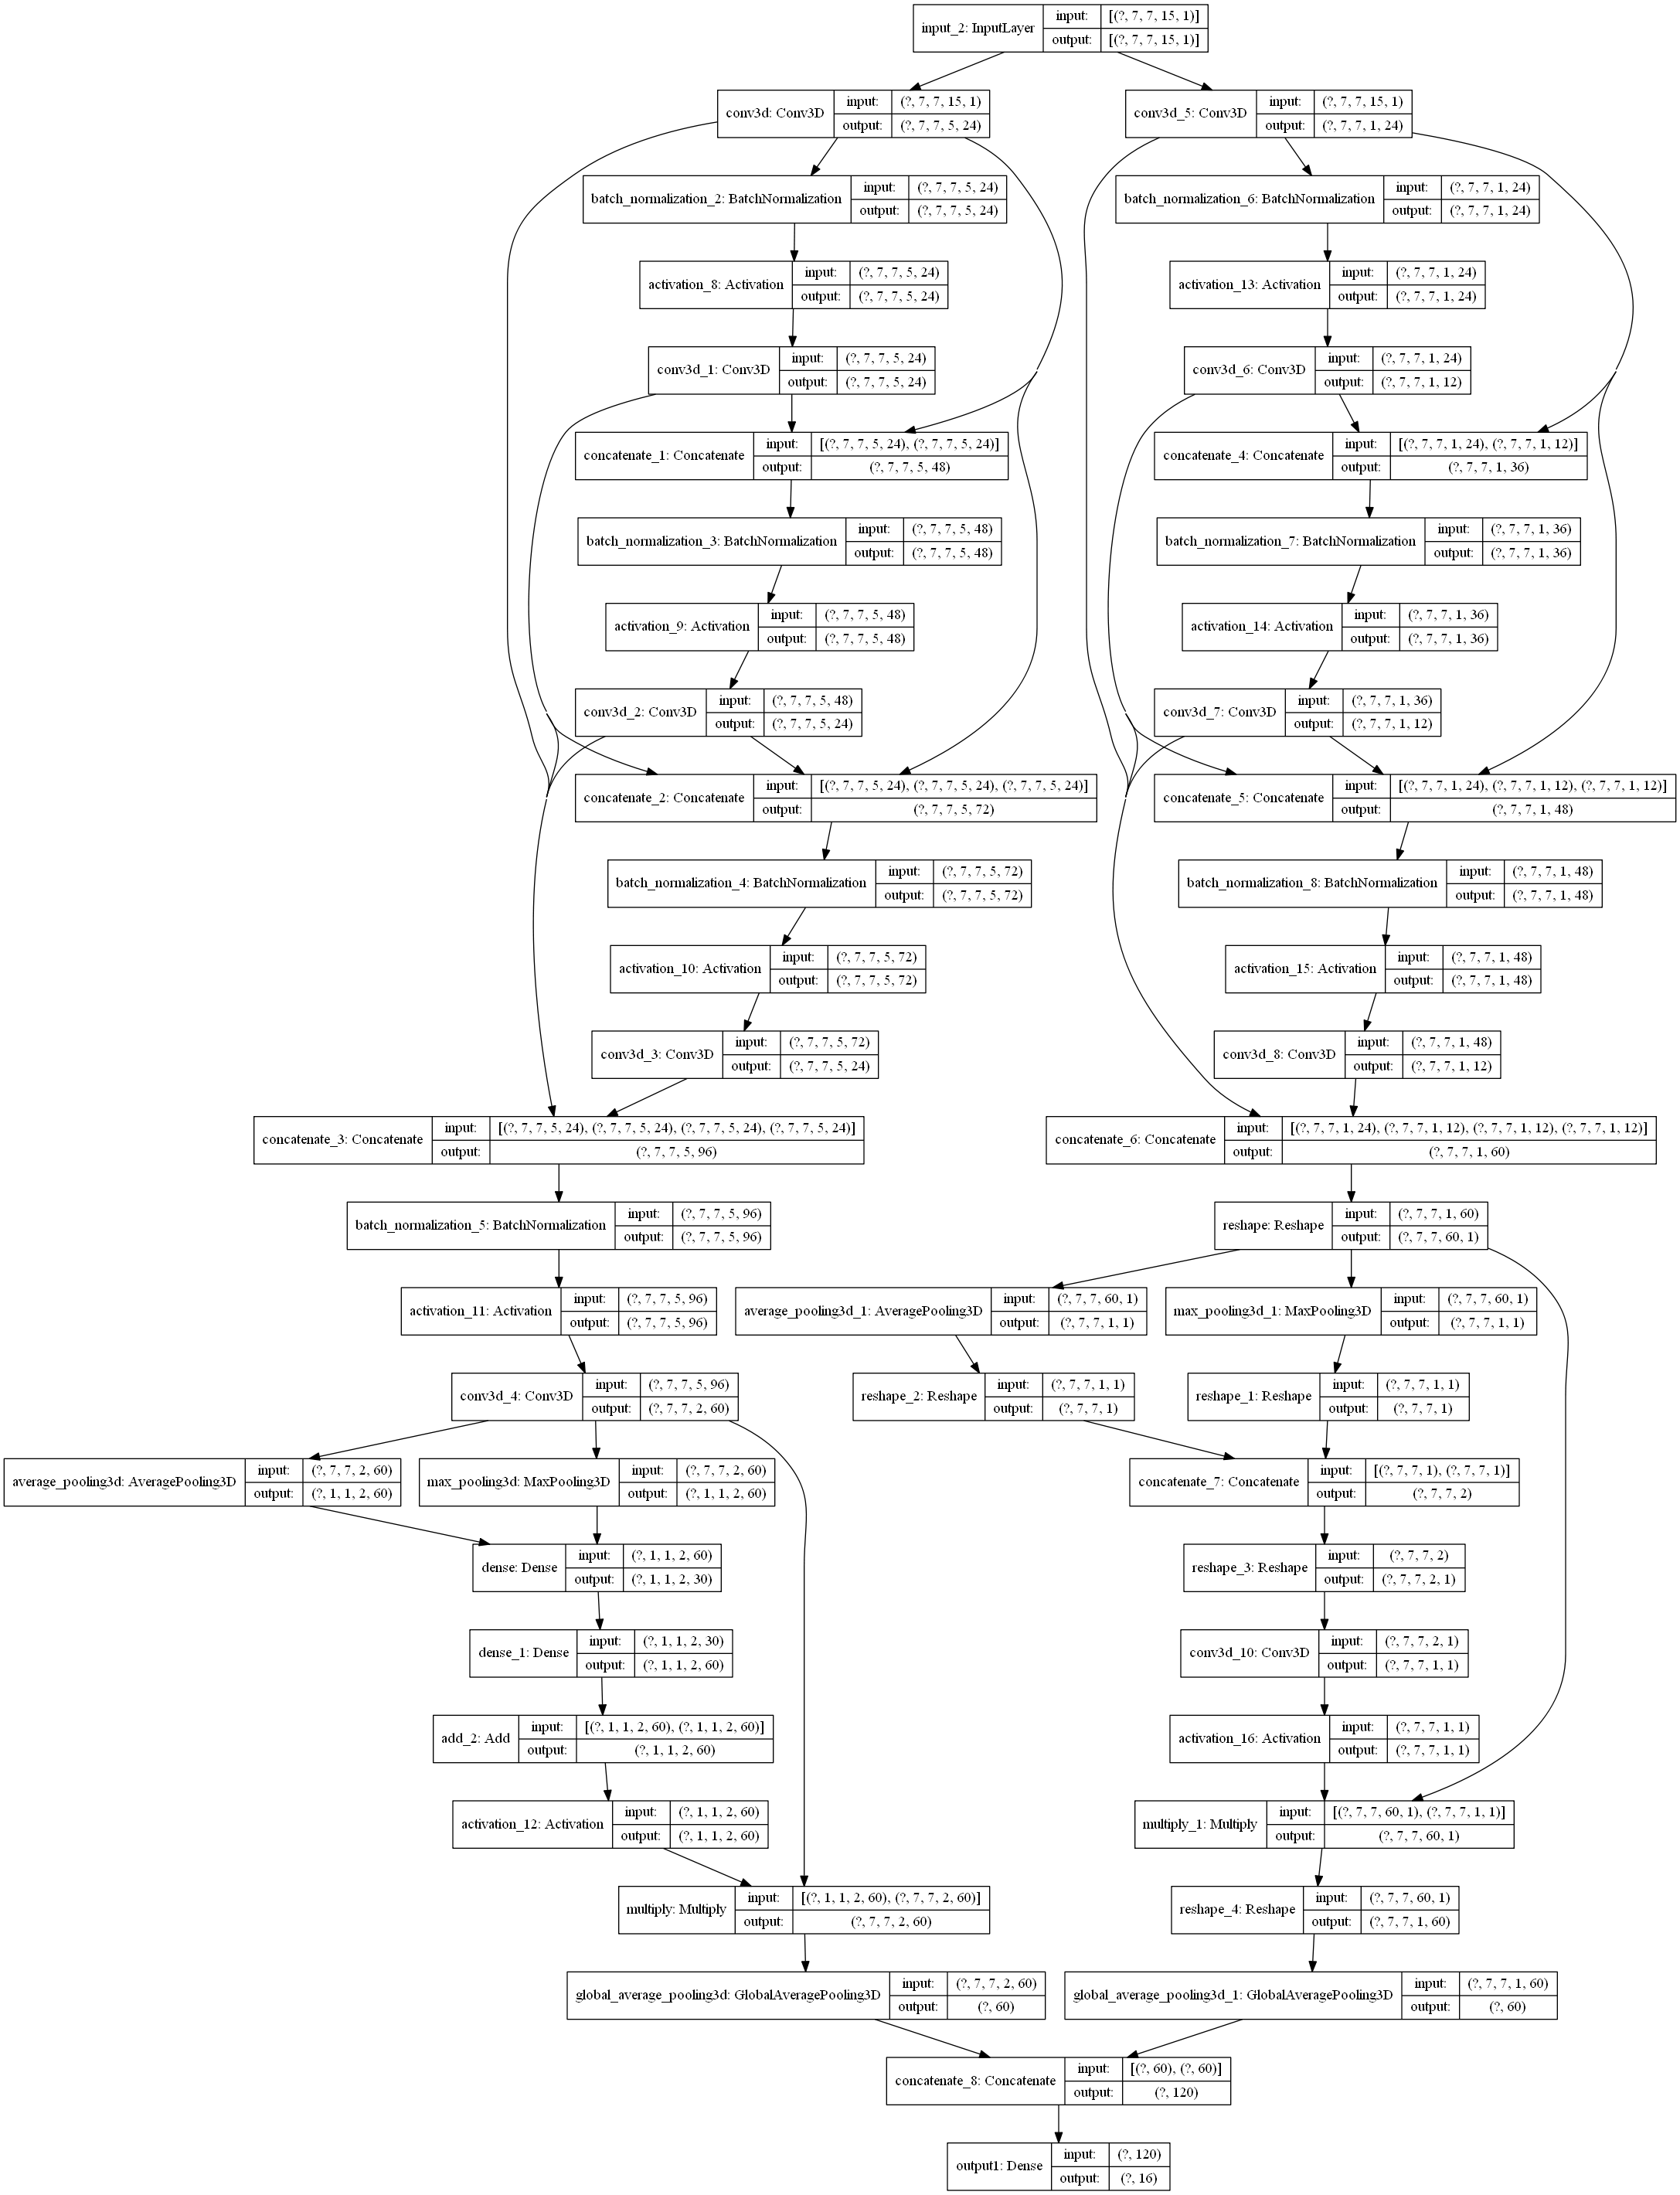

In [7]:
keras.utils.plot_model(model, 'model_dbma.png', show_shapes=True)

In [6]:
time1 = int(time.time())
# first train the model with lr=1.0    
model.compile(loss='categorical_crossentropy',optimizer=adadelta1,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=20,epochs=80,verbose=0,shuffle=True)

# then train the model with lr=0.1; if loss not decrease for 5 epoches, stop training
model.compile(loss='categorical_crossentropy',optimizer=adadelta2,metrics=['accuracy'])   
model.fit(x_train,y_train,batch_size=20,epochs=20,verbose=0,shuffle=0,callbacks=[early_stopping])
time2 = int(time.time())

# predict
y_pred = np.argmax(model.predict(x_test), axis=1)
oa = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print('DBMA:', oa, kappa, ' Time Comsumption:', time2-time1)

DBMA: 0.973550135501355 0.9698450898498162  Time Comsumption: 195


# SSRN
https://github.com/zilongzhong/SSRN

In [2]:
from Utils import ssrn_SS_IN

patch = 7  
nb_classes = np.max(GT)

data_norm = HSI.reshape(np.prod(HSI.shape[:2]),np.prod(HSI.shape[2:]))
data_norm = scale(data_norm)
data_norm = data_norm.reshape(HSI.shape[0], HSI.shape[1],HSI.shape[2])
#im = applyPCA(data_norm,numComponents=15)
im = data_norm

X, y = createImageCubes(im, GT, windowSize=patch)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3], 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345, stratify=y)
y_train = keras.utils.to_categorical(np.asarray(y_train))
VAL_SIZE = int(0.1*X.shape[0])
x_val = x_test[-VAL_SIZE:]
y_val = keras.utils.to_categorical(np.asarray(y_test))[-VAL_SIZE:]
x_test = x_test[:-VAL_SIZE]
y_test = y_test[:-VAL_SIZE]

# SSRN 4 with BN
model = ssrn_SS_IN.ResnetBuilder.build_resnet_8((1, patch, patch, im.shape[2]), nb_classes)
RMS = keras.optimizers.RMSprop(lr=0.0003)
model.compile(loss='categorical_crossentropy', optimizer=RMS, metrics=['accuracy'])

model.summary()
print('PatchSize:', patch, 'FLOPs:', format(count_FLOPs(model), ','))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 7, 200, 1 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 7, 7, 97, 24) 192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 97, 24) 96          conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 7, 7, 97, 24) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

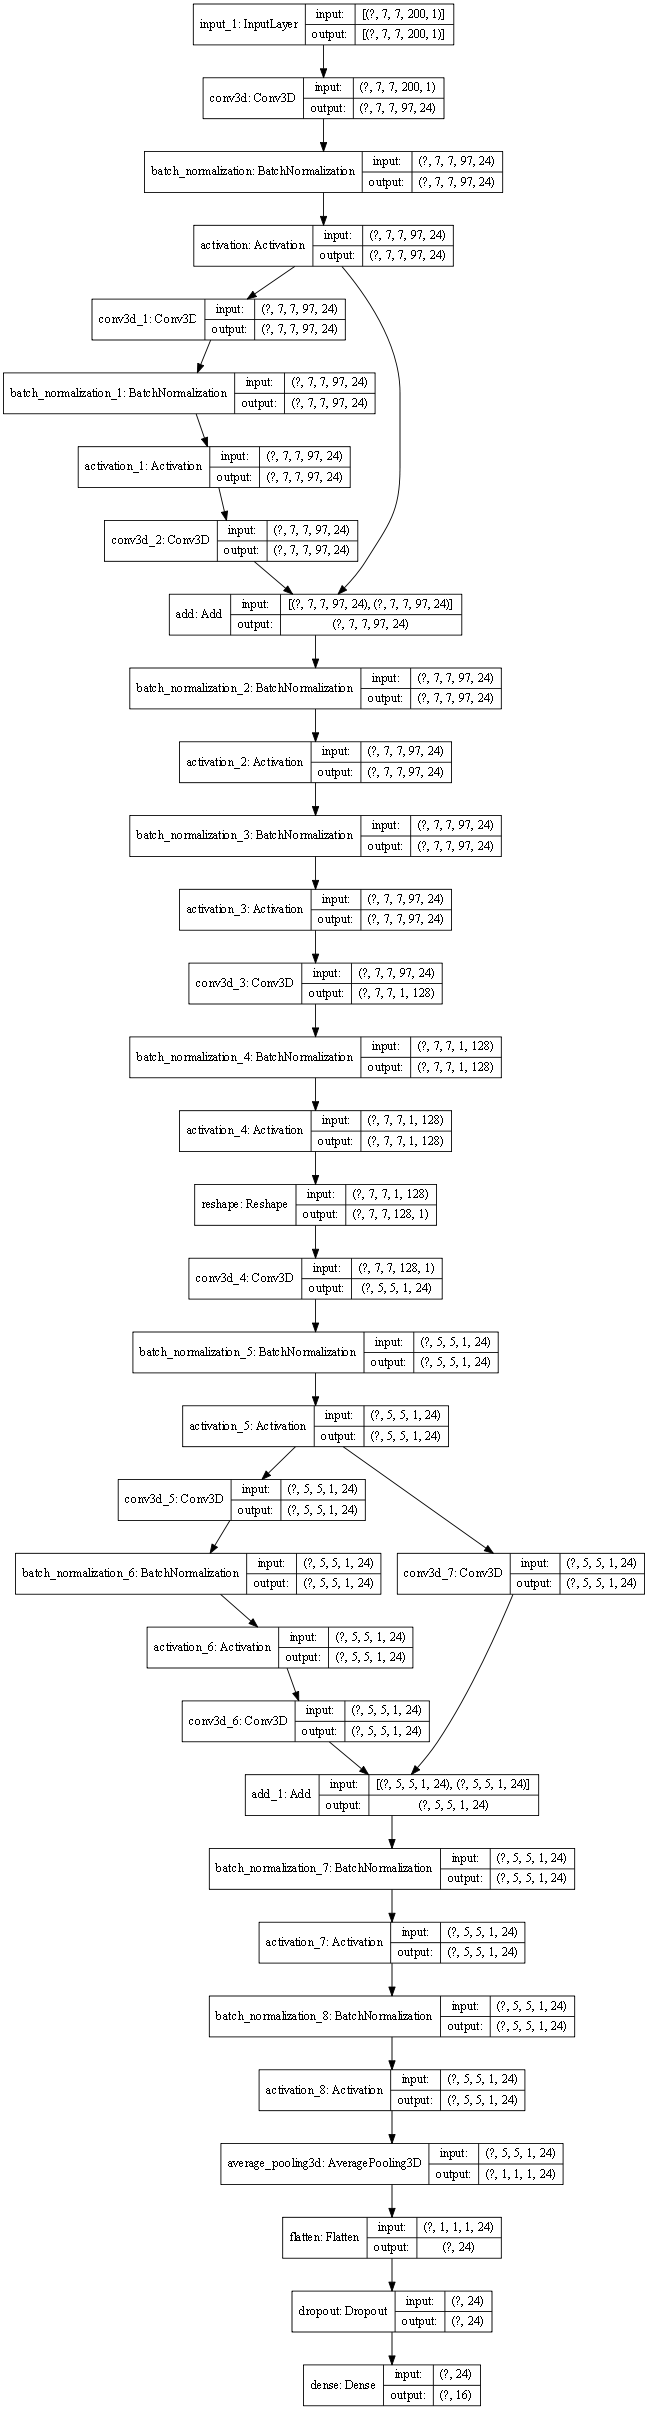

In [3]:
keras.utils.plot_model(model, 'model_ssrn.png', show_shapes=True, dpi = 64)

In [4]:
time1 = int(time.time())
# training
model.fit(x_train, y_train, batch_size=16, epochs=100, shuffle=False, verbose=0)
time2 = int(time.time())

# predict
y_pred = np.argmax(model.predict(x_test), axis=1)
oa = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print('SSRN:', oa, kappa, ' Time Comsumption:', time2-time1)

SSRN: 0.9746372393610535 0.9710045934845394  Time Comsumption: 242


# HybridSN
https://github.com/gokriznastic/HybridSN

In [8]:
patch = 25
PCsNum = 15
HPCs = applyPCA(HSI,numComponents=PCsNum)

X, y = createImageCubes(HPCs, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
Xtrain = Xtrain.reshape(-1, patch, patch, PCsNum, 1)
Xtest = Xtest.reshape(-1, patch, patch, PCsNum, 1)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
input_layer = keras.Input((patch, patch, PCsNum, 1))

## convolutional layers
conv_layer1 = keras.layers.Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv3d_shape = conv_layer3.shape
conv_layer3 = keras.layers.Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = keras.layers.Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = keras.layers.Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = keras.layers.Dropout(0.4)(dense_layer1)
dense_layer2 = keras.layers.Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = keras.layers.Dropout(0.4)(dense_layer2)
output_layer = keras.layers.Dense(units=ytrain.shape[1], activation='softmax')(dense_layer2)

model = keras.models.Model(inputs=input_layer, outputs=output_layer, name='HybridSN')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()
print('PatchSize:', patch, 'FLOPs:', format(count_FLOPs(model), ','))

Model: "HybridSN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 25, 25, 15, 1)]   0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 23, 23, 9, 8)      512       
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 21, 21, 5, 16)     5776      
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 19, 19, 3, 32)     13856     
_________________________________________________________________
reshape_11 (Reshape)         (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 17, 17, 64)        55360     
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0  

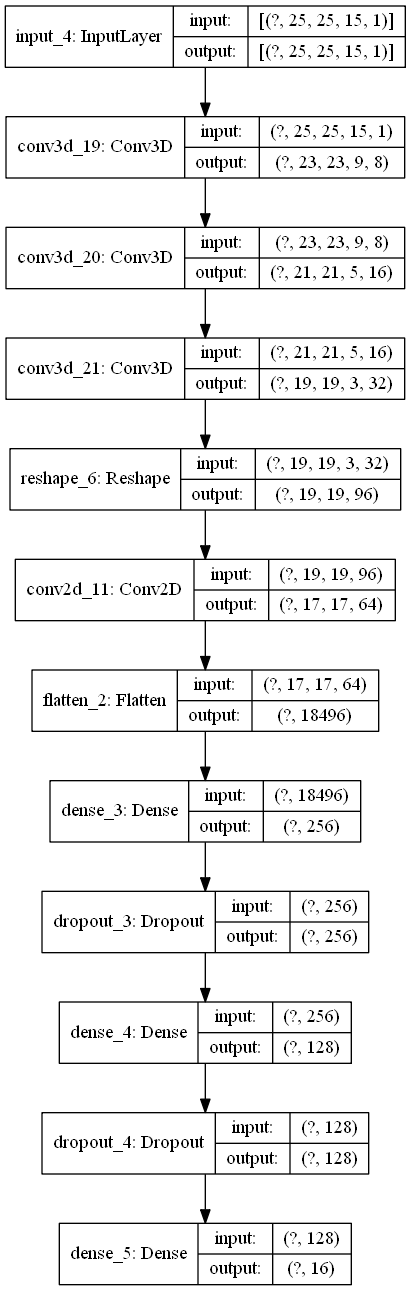

In [13]:
keras.utils.plot_model(model, 'model_hybridsn.png', show_shapes=True)

In [10]:
for j in range(1):
    time1 = int(time.time())
    # training
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)     
    time2 = int(time.time())
    
    # predict
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    kappa = cohen_kappa_score(ytest, y_pred)

    print('Hybrid:', oa, kappa, ' Time Comsumption:', time2-time1)

Hybrid: 0.9778861788617886 0.9747731307662696  Time Comsumption: 78


# ClusterCNN

In [2]:
patch = 25
PCsNum = 15
ClusterNum = 100   
HPCs = applyPCA(HSI,numComponents=PCsNum)

start_time = time.process_time()
clusterstack = np.zeros(HPCs.shape)
cluster_algorithm = 'minikmeans' # default = 'minikmeans'

mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = mbk_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)
    
timeused = (time.process_time() - start_time)
print(f'{cluster_algorithm}.  Clustering Time:{timeused}s.  # of Clusters:{np.max(clusterlabel)+1}')

minikmeans.  Clustering Time:0.9375s.  # of Clusters:100


In [3]:
X, y = createImageCubes(clusterstack, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()
print('PatchSize:', patch, 'FLOPs:', format(count_FLOPs(model), ','))

Model: "2DCNN_FCs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IL (InputLayer)              [(None, 25, 25, 15)]      0         
_________________________________________________________________
C1 (Conv2D)                  (None, 21, 21, 64)        24064     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
C2 (Conv2D)                  (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
FL (Flatten)                 (None, 1024)              0         
_________________________________________________________________
D1 (Dense)                   (None, 128)               13

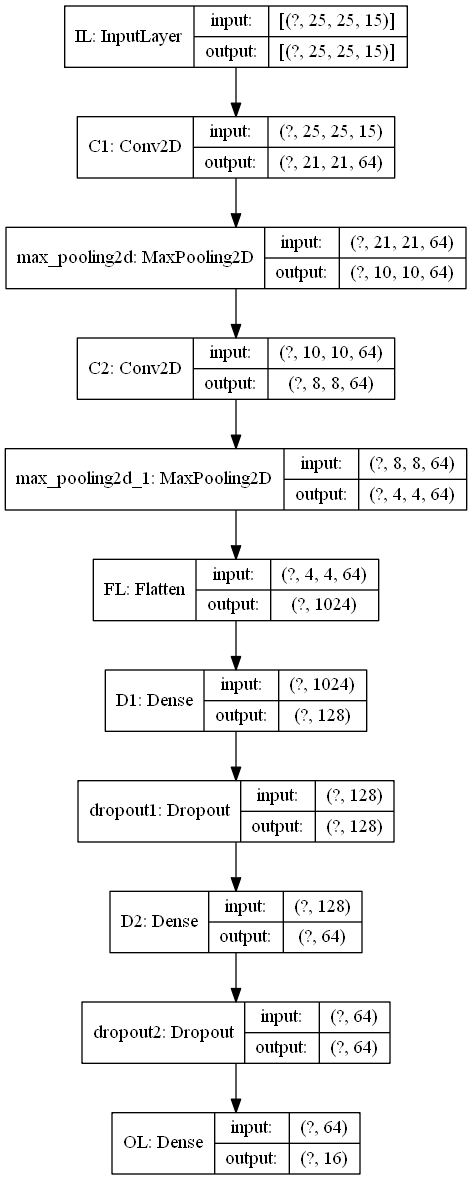

In [4]:
keras.utils.plot_model(model, 'model_clustercnn.png', show_shapes=True)

In [5]:
start_time = time.process_time()
# training
model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)
training_time = time.process_time()-start_time

# predict
y_pred = np.argmax(model.predict(Xtest), axis=1)
oa = accuracy_score(ytest, y_pred)
kappa = cohen_kappa_score(ytest, y_pred)

print('ClusterCNN:', oa, kappa, ' Training Time:', training_time)

ClusterCNN: 0.9859078590785908 0.9839274145556631  Training Time: 24.765625


## ClusterCNN with very few Clusters

In [14]:
patch = 25
PCsNum = 15
ClusterNum = 20    
HPCs = applyPCA(HSI,numComponents=PCsNum)

start_time = time.process_time()
clusterstack = np.zeros(HPCs.shape)

cluster_algorithm = 'minibatchKmeans'
mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = mbk_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)

timeused = (time.process_time() - start_time)
print(f'{cluster_algorithm}.  Clustering Time:{timeused}s.  # of Clusters:{np.max(clusterlabel)+1}')

X, y = createImageCubes(clusterstack, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
#D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
#D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)

model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')

# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

start_time = time.process_time()
# training
model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, verbose=0)
training_time = time.process_time()-start_time

# predict
y_pred = np.argmax(model.predict(Xtest), axis=1)
oa = accuracy_score(ytest, y_pred)
kappa = cohen_kappa_score(ytest, y_pred)

print('ClusterCNN:', oa, kappa, ' Training Time:', training_time)

minibatchKmeans.  Clustering Time:0.90625s.  # of Clusters:20
ClusterCNN: 0.9823306233062331 0.9798342088796563  Training Time: 37.875


## ClusterCNN with DBSCAN

In [8]:
patch = 25
PCsNum = 15
HPCs = applyPCA(HSI,numComponents=PCsNum)

start_time = time.process_time()
clusterstack = np.zeros(HPCs.shape)

cluster_algorithm = 'density'
dbcluster = cluster.DBSCAN().fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = dbcluster.labels_.reshape((GT.shape))

for i in range(np.max(clusterlabel)+1):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)

timeused = (time.process_time() - start_time)
print(f'{cluster_algorithm}.  Clustering Time:{timeused}s.  # of Clusters:{np.max(clusterlabel)+1}')

X, y = createImageCubes(clusterstack, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)

model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')

# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

start_time = time.process_time()
# training
model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)
training_time = time.process_time()-start_time

# predict
y_pred = np.argmax(model.predict(Xtest), axis=1)
oa = accuracy_score(ytest, y_pred)
kappa = cohen_kappa_score(ytest, y_pred)

print('ClusterCNN:', oa, kappa, ' Training Time:', training_time)

density.  Clustering Time:2.265625s.  # of Clusters:176
ClusterCNN: 0.981680216802168 0.9791076317083227  Training Time: 26.15625


## ClusterCNN without Clustering

In [15]:
patch = 25
PCsNum = 15
ClusterNum = 100    
HPCs = applyPCA(HSI,numComponents=PCsNum)

clusterstack = HPCs

X, y = createImageCubes(clusterstack, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
#D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
#D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)

model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')

# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

start_time = time.process_time()
# training
model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, verbose=0)
training_time = time.process_time()-start_time

# predict
y_pred = np.argmax(model.predict(Xtest), axis=1)
oa = accuracy_score(ytest, y_pred)
kappa = cohen_kappa_score(ytest, y_pred)

print('Just CNN:', oa, kappa, ' Training Time:', training_time)

Just CNN: 0.9826558265582656 0.9802153473652184  Training Time: 31.34375


# UnmixingCNN

Robust-NMF: https://github.com/neel-dey/robust-nmf  

In [17]:
from LibUnmixing import unmixing, unmixing2
patch = 25
PCsNum = 15
HPCs = applyPCA(HSI,numComponents=PCsNum)
_, coeff, _, _ = unmixing2.robust_nmf(data=(HPCs+6).reshape(-1,PCsNum).T, rank=PCsNum, beta=1.5, reg_val=1, sum_to_one=1)

Initializing rNMF uniformly at random.
Iter = 0; Obj = 2769555.612568974
Iter = 100; Obj = 35610.99997136761; Err = 0.007372197825480962
Iter = 200; Obj = 17143.848039358112; Err = 0.007504384115859581
Iter = 300; Obj = 8354.481428385323; Err = 0.005777456984364269
Iter = 400; Obj = 5834.713578842055; Err = 0.001975190614244651
Iter = 500; Obj = 5133.713068270412; Err = 0.0008399367842885703
Iter = 600; Obj = 4817.17168527203; Err = 0.0004925391426554368
Iter = 700; Obj = 4623.6518816623; Err = 0.00034492829976293847
Iter = 800; Obj = 4486.349362401946; Err = 0.0002653098192709742
Iter = 900; Obj = 4380.199576207224; Err = 0.00021634273567103444
Iter = 1000; Obj = 4294.654730420127; Err = 0.00018053015365937663
Maximum number of iterations achieved


In [20]:
X, y = createImageCubes(coeff.T.reshape(HPCs.shape), GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

start_time = time.process_time()
# training
model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)
training_time = time.process_time()-start_time

# predict
y_pred = np.argmax(model.predict(Xtest), axis=1)
oa = accuracy_score(ytest, y_pred)
kappa = cohen_kappa_score(ytest, y_pred)

print('ClusterCNN:', oa, kappa, ' Training Time:', training_time)

ClusterCNN: 0.9802710027100271 0.9774840309215822  Training Time: 24.875
